# Задача

#### Идея A/B тестирования очень проста. Пользователи ресурса случайным образом делятся на сегменты. Один из сегментов остается без изменений — это контрольный сегмент “A”, на основе данных по этому сегменту мы будем оценивать эффект от вносимых изменений. Пользователям из сегмента “B” показываем измененную версию ресурса.
#### Имеется датасет, в нем представлены результаты, где пользователи сайта просмотрели старую и новую веб-страницу.
#### Целью этого теста было определить, влияет ли новая веб-страница на увеличение числа конверсии по сравнению со старой.

In [51]:
# Импортирование библиотек
import pandas as pd
import numpy as np
import scipy.stats

### 1. Загрузка данных

In [44]:
df = pd.read_csv(r'ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


user_id - id пользователя<br>
timestamp - время и дата посещения сайта<br>
group - принадлежность пользователя к определенной группе(контрольной и экспериментальной)<br>
landing_page - версия страницы, которую видит пользователь<br>
converted - говорит о том, сделал ли пользователь покупку<br>


### 2. Анализ данных

Проверяем датасет на пропущенные значения; пропущенных значений нет

In [45]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [46]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

Однако есть пользователи, которые видели обе версии сайтов, их необходимо удалить<br>
Считаем количество вхождений id пользователя, оставляем только тех, кто встречается один раз

##### Визуально различий в разных версиях сайта нет

<AxesSubplot:xlabel='group,landing_page,converted'>

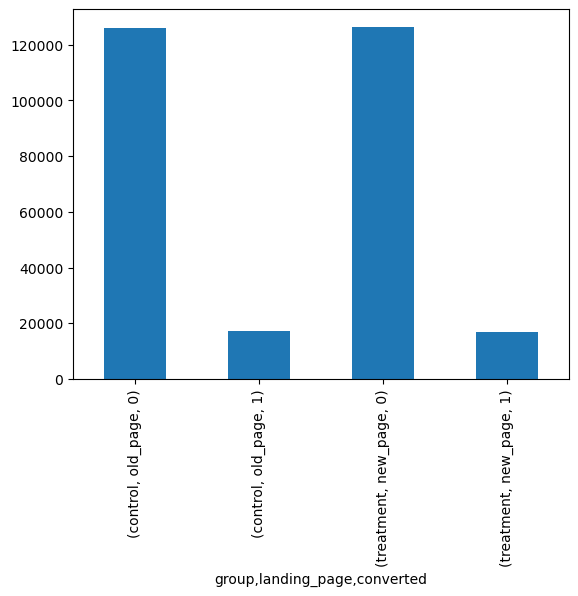

In [48]:
temp_df = df.user_id.value_counts()
temp_df = temp_df[temp_df>1].index
df = df[~df['user_id'].isin(temp_df)]
df.groupby(['group', 'landing_page']).count()
df.groupby(['group', 'landing_page', 'converted']).size().plot.bar()

##### Разбиваем на датафреймы с контрольной и экспериментальной группой

In [49]:
control_df = df.query('group == "control"')
treatment_df = df.query('group == "treatment"')
control_converted = control_df.query('converted == 1').shape[0]
control_not_converted = control_df.shape[0] - control_df.query('converted == 1').shape[0]
treatment_converted = treatment_df.query('converted == 1').shape[0]
treatment_not_converted = treatment_df.shape[0] - treatment_df.query('converted == 1').shape[0]

##### Вычисляем значения CTR для каждой группы

In [50]:
a_ctr = control_converted/control_df.shape[0]
b_ctr = treatment_converted/treatment_df.shape[0]
print(a_ctr, b_ctr)

0.12017335110577627 0.11872633318688676


##### Рассчитаем Хи-квадрат

In [52]:
Chi = np.array([[control_converted,control_not_converted], [treatment_converted,treatment_not_converted]])
scipy.stats.chi2_contingency(Chi, correction=False)[1]

0.23228827305833816

##### p-value больше, чем 0,05
##### Причины отвергнуть нулевую гипетезу нет, разница в конверсии между старой и новой страницей не значительна